In [4]:
import cv2 #import OpenCV
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

%matplotlib inline

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Setting the path
df_path = "../data/1.0-bbri-dataframe.csv"

img_path = "../data/processed/"

# Temporarily to my own folder
img_path = "G:/Meine Ablage/Colab Notebooks/data/processed/"

# Defining format
format_x = 128
format_y = 128
format_z = 3

print(os.getcwd())



c:\Users\Bernd\Documents\GitHub\apr24_bds_int_plant_recognition\notebooks


In [5]:
def build_data(df):
  data = []

  # Iterating through our dataframe
  for index, row in df.iterrows():

  # Reading image
    dirname = row.Image_folder + "/"
    filename = row.Image_name

    to_read = img_path + dirname + filename
    img = cv2.imread(to_read, cv2.IMREAD_COLOR)

  # Appending image as element to our list
    data = np.append(data, img)

  return data

def generate_data(threshold):
  # Creating an empty data structure for our data
  X_train = []
  X_test = []
  y_train = []
  y_test = []

  # Reading the dataframe
  df = pd.read_csv(df_path, index_col = 0)

  # Filter to temporarily reduce magnitude of data during evaluation period
  df = df [(df.Plant == "Sugar beet") | (df.Plant == "Strawberry") ]

# In addition we temporarily cut our dataset to 20% of its original size for speed reasons#
#  n = round(df.shape[0] * 0.2)
#  df = df.sample(n = n, random_state = 42)

  # We add a column to our dataframe in order to represent a number for each plant
  label_encoder = LabelEncoder()
  df["Plant_num"] = label_encoder.fit_transform(df.Plant)

  # Determine threshold for train data
  n = round(df.shape[0] * threshold)

  # Split dataframe for training and testing purposes
  df1 = df.sample(n = n, random_state = 42)
  df2 = df.drop(df1.index)

  # Build train and test data
  X_train = build_data(df1)
  X_test = build_data(df2)

  # Reshaping list to target format
  X_train = X_train.reshape(-1, format_x, format_y, format_z)
  X_test = X_test.reshape(-1, format_x, format_y, format_z)

  # Build target vector for train and test set
  y_train = df1.Plant_num
  y_test = df2.Plant_num

  return X_train, X_test, y_train, y_test


In [6]:
# Running this cell took around 4 min 16 sec for loading 2.028 images of shape 128 x 128 x 3 on May 22 2024
X_train, X_test, y_train, y_test = generate_data(threshold = 0.8)

In [7]:
# Transforming the data - Please ensure to execute this cell only once!
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [8]:
# Building our first CNN model
inputs = Input(shape = (128, 128, 3), name = "Input")
first_layer  = Conv2D(filters = 32, #The layer will be composed of 32 convolution matrices.
                      kernel_size = (5, 5), #the convolution kernel will be of dimension 5x5 (25 neurons per filter).
                      padding = 'valid', #so that the kernel cannot exceed the edges of the image.   
                      activation = 'relu')
    
second_layer = MaxPooling2D(pool_size = (2, 2))
third_layer = Dropout(rate = 0.2)
fourth_layer = Flatten()
fifth_layer  = Dense(units = 128, activation = "relu")
output_layer = Dense(units = 2, activation = "softmax")
#output_layer = Dense(units = 10, activation = "softmax")

x = first_layer(inputs)
x = second_layer(x)
x = third_layer(x)
x = fourth_layer(x)
x = fifth_layer(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

In [9]:
# Compiling the model
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

training_history = model.fit(X_train, y_train, epochs = 10, batch_size = 200, validation_split = 0.2)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 677ms/step - accuracy: 0.7604 - loss: 4.3489 - val_accuracy: 0.2246 - val_loss: 1.3292
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.4827 - loss: 0.9001 - val_accuracy: 0.7754 - val_loss: 0.3888
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.7701 - loss: 0.3964 - val_accuracy: 0.7754 - val_loss: 0.3428
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 608ms/step - accuracy: 0.7804 - loss: 0.3227 - val_accuracy: 0.7754 - val_loss: 0.2688
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - accuracy: 0.7990 - loss: 0.2537 - val_accuracy: 0.9723 - val_loss: 0.2013
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 596ms/step - accuracy: 0.9617 - loss: 0.1806 - val_accuracy: 0.9846 - val_loss: 0.1428
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 622ms/step - accuracy: 0.9761 - loss: 0.1268 - val_accuracy: 0.9846 - val_loss: 0.0944
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 601ms/step - accuracy: 0.9870 - loss: 0.0768 - val_accuracy: 0.9877 - val_loss:

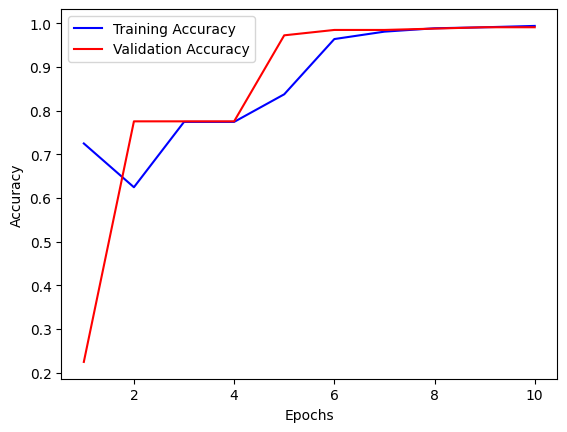

In [10]:
# Assessing the training history
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

# Axis labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Precision curve on the training sample
plt.plot(np.arange(1 , 11, 1),
         training_history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

# Accuracy curve on the test sample
plt.plot(np.arange(1 , 11, 1),
         training_history.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.legend()
plt.show()


In [11]:
# Applying the model
test_pred = model.predict(X_test)

test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_class))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       309
           1       1.00      1.00      1.00        97

    accuracy                           1.00       406
   macro avg       1.00      1.00      1.00       406
weighted avg       1.00      1.00      1.00       406



In [12]:
# Printing the confusion matrix
#cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
#print(cnf_matrix)

pd.crosstab(test_pred_class, y_test_class, rownames=['Real classification'], colnames=['Predicted classification'])


Predicted classification,0,1
Real classification,,
0,309,0
1,0,97
